# Dynamic Weather Sensitivity in NEWT

Major departures in watershed conditions are often well past routine weather swings.  However, modeling variable seasonality still tends to miss peaks and a lot of variation throughout the spring and summer, so what's going on there?  New hypothesis: it's still weather sensitivity, but non-stationary weather sensitivity.  A snowy watershed is still a snowy watershed, but with a dry winter it ends up being much more sensitive to warm days.  Notably, a lot of the missed peaks in Eagle River are big, short spikes that the stationary model catches, but underestimates.

In [64]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
from NEWT import Watershed as WS
pd.options.mode.chained_assignment = None

def trycatch(op):
    try:
        return op()
    except ValueError:
        return None

In [65]:
data = pd.read_csv("AllData.csv", dtype={"id": "str"}).rename(columns={"temperature.mean": "temperature"})
data["date"] = pd.to_datetime(data["date"])

def get_candidate(cid):
    return data[data["id"] == cid]

In [66]:
# This is Eagle River Below Milk Creek Near Wolcott, CO
# Appears to be unregulated, freezes in winter, max temperature ~20 C, discharge ~50-2000 cfs,
# elevation ~2100 m
candidate_eagle = "394220106431500"

cid = candidate_eagle
csd = get_candidate(cid).assign(year = lambda x: x["date"].dt.year,
                               day = lambda x: x["date"].dt.day_of_year)

## Eagle River AT Anomaly

For a first test, let's look at AT anomaly alone, which is easy to extract by setting VP coefficient to zero and AT coefficient to 1.

Years to focus on are 2010, 2012, 2013, 2015, 2018, 2021, and 2022.

In [67]:
mod = WS.from_data(csd)
mod.vp_coef = 0
mod.at_coef = 1
pred = mod.run_series(csd).assign(st_anom = lambda x: x["temperature"] - x["actemp"])

<Axes: >

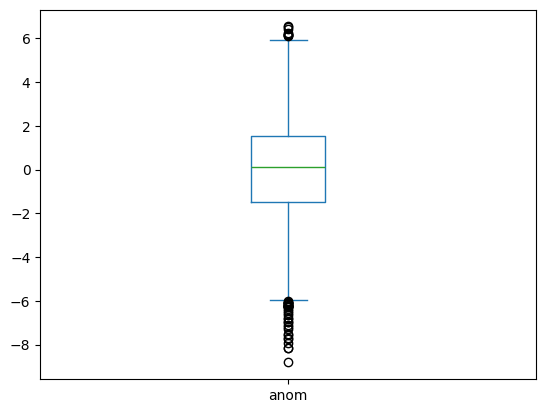

In [68]:
# ax = sns.lineplot(x="date", y="temperature", data=pred)
# sns.lineplot(x="date", y="actemp", data=pred, ax=ax)
pred["anom"].plot.box()

At a glance, there are three "bundles": one more responsive (mean ~ 0, contains the largest positive anomalies of 1.5-3 C), one less responsive (mean < 0), and one more responsive with mean << 0.  It seems that different years do have discrete slopes, plus a constant offset (better handled by modeling Intercept using an established year-engine).  Here, I'll focus on slope, not Intercept.

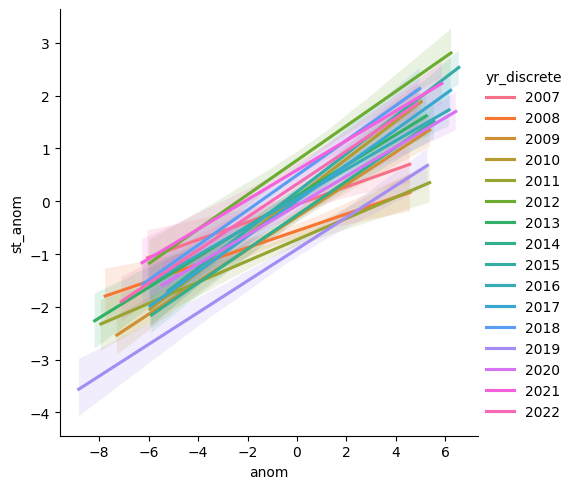

In [69]:
pred["yr_discrete"] = pred["year"].apply(str)
# fig = plt.figure(figsize=(12,8))
# ax = plt.axes()
sns.lmplot(x="anom", y="st_anom", data=pred, hue="yr_discrete", scatter=False)

## Slope Modeling

In [70]:
def fit_slope(data):
    # data = data[(data["day"] > 150) & (data["day"] < 270)]
    x = data["anom"].to_numpy()
    x = np.array([np.ones(x.shape), x]).transpose()
    y = data["st_anom"].to_numpy()
    return np.linalg.lstsq(x, y, rcond=None)[0][1]

As a general comment, there is non-trivial variation in the slopes.  The non-outlier range of weighted anomalies is about $\pm$6 degrees, so the non-outlier anomaly range here of 0.2-0.35 could explain missing a peak by up to a degree.  That doesn't fully explain it, but it's certainly a start.

Limited to day 150-270, the IQR is small but the outlier range is huge, 0-0.8.

<Axes: >

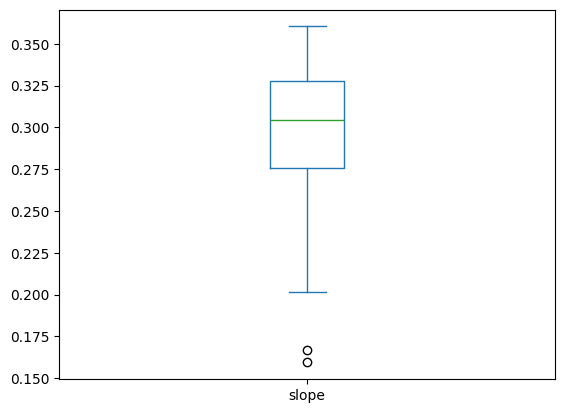

In [71]:
slopes = pred.groupby("year").apply(fit_slope, include_groups=False).rename("slope")
slopes.plot.box()

For Eagle River, a whopping $R^2$ of 0.65 is attainable just on `tmax`, specifically from day 330-90.  So how does that affect performance?  Maximum $R^2$ is much lower with just summer coefficient, so that's not promising.

In [72]:
def tmcor(doymin, doymax):
    weather = pred[(pred["day"] >= doymin) & (pred["day"] <= doymax)] if doymax > doymin else pred[(pred["day"] >= doymin) | (pred["day"] <= doymax)]
    weather = weather.groupby("year")[["prcp", "srad", "tmax", "vp"]].mean().merge(slopes, on="year")
    return weather.corr() #.loc["tmax", "slope"]

tmcor(1, 90)
# pairs = pd.DataFrame({"doymin": [1, 30, 60, 90, 300, 330]}).merge(pd.Series([330, 365, 30, 60, 90, 120, 150, 180], name="doymax"), how="cross")
# pd.concat([
#     pd.DataFrame({"doymin": [x.doymin], "doymax": x.doymax, "cor": tmcor(x.doymin, x.doymax)**2})
#     for x in pairs.itertuples()
# ]).sort_values("cor", ascending=False)

,prcp,srad,tmax,vp,slope
prcp,1.000000,-0.326555,-0.555492,-0.197387,-0.621169
srad,-0.326555,1.000000,0.027028,-0.261119,0.250953
tmax,-0.555492,0.027028,1.000000,0.864923,0.765169
vp,-0.197387,-0.261119,0.864923,1.000000,0.572610
slope,-0.621169,0.250953,0.765169,0.572610,1.000000


In [73]:
weather = pred[(pred["day"] >= 330) | (pred["day"] <= 90)].groupby("year")[["prcp", "srad", "tmax", "vp"]].mean().merge(slopes, on="year")
weather

,prcp,srad,tmax,vp,slope
year,,,,,
2007,3.493369,213.476827,-3.214445,241.595975,0.167114
2008,3.554126,327.409884,-1.585087,252.609763,0.159470
2009,2.230055,323.258969,0.159825,285.864689,0.307356
2010,2.024617,333.559285,0.616195,283.442364,0.358506
2011,2.386258,324.291644,0.119804,265.497934,0.201453
2012,1.644054,334.974767,1.482961,286.259135,0.326552
2013,1.743764,324.819138,-0.513829,252.389681,0.289419
2014,2.915862,334.513950,0.830227,301.618338,0.321641
2015,1.618377,331.026635,2.062878,313.589660,0.360311


In [74]:
x = weather["tmax"].to_numpy()
x = np.array([np.ones(x.shape), x]).transpose()
y = weather["slope"].to_numpy()
fit = np.linalg.lstsq(x, y, rcond=None)[0]
fit

array([0.27505692, 0.03686728])

In [75]:
weather["pred_slope"] = x @ fit

In [76]:
weather

,prcp,srad,tmax,vp,slope,pred_slope
year,,,,,,
2007,3.493369,213.476827,-3.214445,241.595975,0.167114,0.156549
2008,3.554126,327.409884,-1.585087,252.609763,0.159470,0.216619
2009,2.230055,323.258969,0.159825,285.864689,0.307356,0.280949
2010,2.024617,333.559285,0.616195,283.442364,0.358506,0.297774
2011,2.386258,324.291644,0.119804,265.497934,0.201453,0.279474
2012,1.644054,334.974767,1.482961,286.259135,0.326552,0.329730
2013,1.743764,324.819138,-0.513829,252.389681,0.289419,0.256113
2014,2.915862,334.513950,0.830227,301.618338,0.321641,0.305665
2015,1.618377,331.026635,2.062878,313.589660,0.360311,0.351110


<Axes: xlabel='slope', ylabel='pred_slope'>

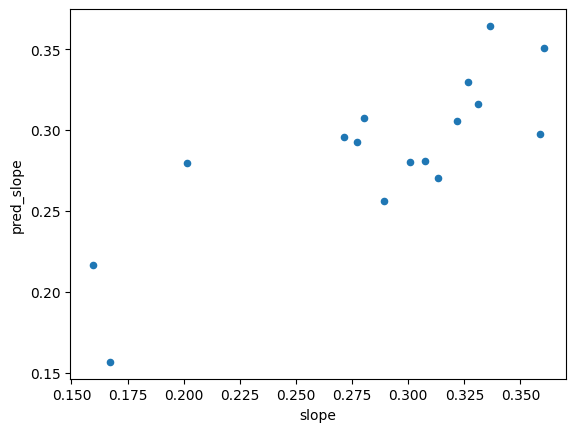

In [77]:
weather.plot.scatter(x="slope", y="pred_slope")

In [78]:
pred = pred.merge(weather["pred_slope"], on="year")

In [79]:
pred["st_base"] = pred["actemp"] + pred["st_anom"] * 0.3  # median
pred["st_fit"] = pred["actemp"] + pred["st_anom"] * pred["pred_slope"]
pred

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,year,day,actemp,anom,temp.mod,st_anom,yr_discrete,pred_slope,st_base,st_fit
0,394220106431500,2007-10-01,9.000000,5.684494,315.89957,NaN,14.848049,-0.734184,579.70483,2007,274,10.141775,0.017104,10.158879,-1.141775,2007,0.156549,9.799242,9.963031
1,394220106431500,2007-10-02,10.131250,1.734530,275.11975,NaN,9.678488,-0.441640,593.09650,2007,275,9.872676,-0.053857,9.818819,0.258574,2007,0.156549,9.950248,9.913156
2,394220106431500,2007-10-03,9.704167,0.000000,406.70746,NaN,14.444156,-0.781746,576.83930,2007,276,9.602529,-0.046952,9.555577,0.101637,2007,0.156549,9.633020,9.618441
3,394220106431500,2007-10-04,9.695833,0.405152,387.00244,NaN,16.709568,1.858799,699.66880,2007,277,9.331561,0.198004,9.529565,0.364273,2007,0.156549,9.440843,9.388587
4,394220106431500,2007-10-05,10.901042,0.000000,334.83810,NaN,15.645824,3.965081,813.42255,2007,278,9.059998,0.806556,9.866555,1.841043,2007,0.156549,9.612311,9.348212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5534,394220106431500,2022-12-27,0.000000,10.553032,191.49033,NaN,4.154530,NaN,424.24790,2022,361,-0.555511,2.185967,1.630456,0.555511,2022,0.270649,-0.388857,-0.405162
5535,394220106431500,2022-12-28,0.000000,8.184340,210.25845,NaN,0.119703,NaN,298.54263,2022,362,-0.580520,3.529477,2.948957,0.580520,2022,0.270649,-0.406364,-0.423403
5536,394220106431500,2022-12-29,0.000000,1.973018,218.12827,NaN,-7.772742,NaN,180.07483,2022,363,-0.602905,3.164175,2.561270,0.602905,2022,0.270649,-0.422034,-0.439729
5537,394220106431500,2022-12-30,0.000000,7.100912,229.40940,NaN,-4.506784,NaN,182.08226,2022,364,-0.622671,0.116842,0.000000,0.622671,2022,0.270649,-0.435870,-0.454146


In [80]:
pred[["temperature", "actemp", "st_base", "st_fit"]].corr()**2

,temperature,actemp,st_base,st_fit
temperature,1.000000,0.927741,0.964592,0.964053
actemp,0.927741,1.000000,0.993150,0.993252
st_base,0.964592,0.993150,1.000000,0.999903
st_fit,0.964053,0.993252,0.999903,1.000000


Slope-fitting actually produces a slight penalty to R2, but how does it impact max-capture?

<Axes: >

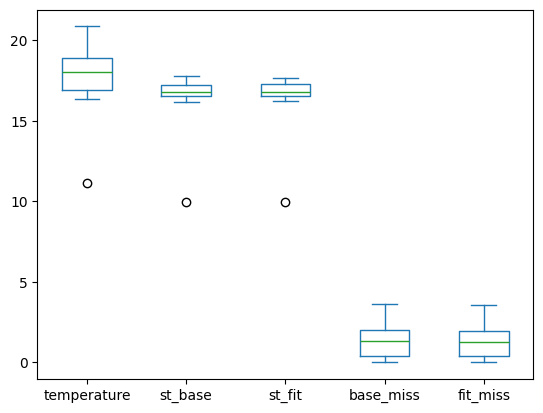

In [81]:
pred.groupby("year")[["temperature", "st_base", "st_fit"]].max().assign(base_miss = lambda x: x["temperature"] - x["st_base"], fit_miss = lambda x: x["temperature"] - x["st_fit"]).plot.box()

<Axes: >

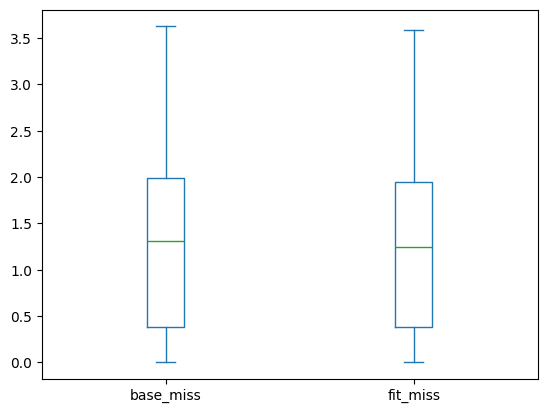

In [82]:
pred.groupby("year")[["temperature", "st_base", "st_fit"]].max().assign(base_miss = lambda x: x["temperature"] - x["st_base"], fit_miss = lambda x: x["temperature"] - x["st_fit"])[["base_miss", "fit_miss"]].plot.box()

There's a nonzero benefit, but small.  What if we look at midyear temperatures only?

Actually, one last idea: let's plot errors against all variables.

In [85]:
pred["error"] = pred["st_base"] - pred["temperature"]